In [ ]:


import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn


from tensorflow import keras
from keras.preprocessing.text import text_to_word_sequence


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/CSE438 (1)/preprocessed_news_article_removing_numbers.csv")

In [ ]:
target_category = dataset['Category'].unique()
print(target_category)

['politics' 'economy' 'entertainment' 'sports' 'technology'
 'international' 'state' 'education']


In [ ]:
dataset['categoryId'] = dataset['Category'].factorize()[0]
dataset.head()

,Category,Text,categoryId,Text_Length,Char_Length,Word_Count
0,politics,গ্যাটকো দুর্নীতি মামলায় বিএনপি চেয়ারপারসন খালে...,0,1646,1646,237
1,economy,সৈয়দ এম ওমর তৈয়ব প্রাইম ব্যাংক উপব্যবস্থাপনা প...,1,466,466,57
2,politics,প্রধান নির্বাচন কমিশন সিইসি কেএম নূরুল হুদ উদ্...,0,2976,2976,467
3,politics,আওয়ামী লীগ সম্পাদক সড়ক পরিবহন সেতুমন্ত্রী ওব...,0,2615,2615,390
4,politics,সোহেল তাজ আস দরজায় রেডি চলতি বছর এপ্রিলে খবরে ...,0,1459,1459,234


In [ ]:
category = dataset[["Category","categoryId"]].drop_duplicates().sort_values('categoryId')
category

,Category,categoryId
0,politics,0
1,economy,1
6,entertainment,2
14,sports,3
19520,technology,4
19522,international,5
19523,state,6
19524,education,7


In [ ]:
dataset.groupby('Category').categoryId.count()

Category
economy          18734
education        12818
entertainment    16959
international    15314
politics         12717
sports           16742
state            15183
technology        9937
Name: categoryId, dtype: int64

<Axes: xlabel='Category'>

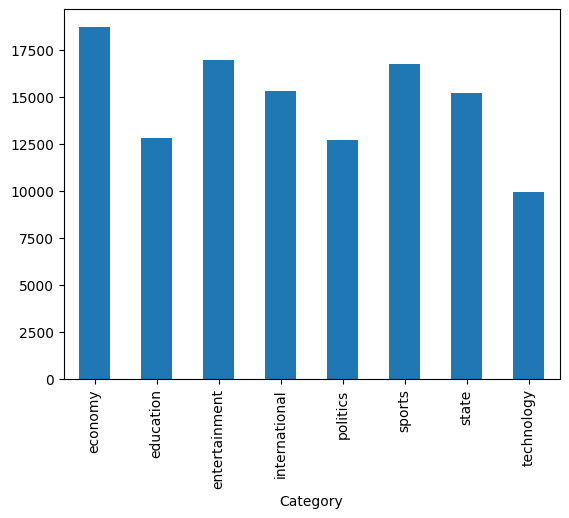

In [ ]:
dataset.groupby('Category').categoryId.count().plot.bar(ylim=0)

In [ ]:
text = dataset['Text']
category = dataset['Category']
text.head()

0    গ্যাটকো দুর্নীতি মামলায় বিএনপি চেয়ারপারসন খালে...
1    সৈয়দ এম ওমর তৈয়ব প্রাইম ব্যাংক উপব্যবস্থাপনা প...
2    প্রধান নির্বাচন কমিশন সিইসি কেএম নূরুল হুদ উদ্...
3    আওয়ামী লীগ সম্পাদক সড়ক পরিবহন সেতুমন্ত্রী ওব...
4    সোহেল তাজ আস দরজায় রেডি চলতি বছর এপ্রিলে খবরে ...
Name: Text, dtype: object

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(text,category, test_size = 0.3, random_state = 60,shuffle=True, stratify=category)

print(len(X_train))
print(len(X_test))

82882
35522


In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
max_len = 200
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

ada_boost_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000)),
    ('clf', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50, learning_rate=1.0))
])
ada_boost_pipeline.fit(X_train, Y_train_encoded)


cnn_model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_len),
    Conv1D(64, 5, activation='relu', padding='valid'),
    MaxPooling1D(),
    Conv1D(128, 5, activation='relu', padding='valid'),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')
])

cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.fit(X_train_padded, Y_train_encoded, batch_size=32, epochs=10, validation_split=0.2)


class KerasClassifierWrapper:
    def __init__(self, keras_model):
        self.keras_model = keras_model

    def fit(self, X, y):
        self.keras_model.fit(X, y, batch_size=32, epochs=10, validation_split=0.2, verbose=0)

    def predict(self, X):
        return np.argmax(self.keras_model.predict(X), axis=1)


cnn_wrapper = KerasClassifierWrapper(cnn_model)


ada_boost_predictions = ada_boost_pipeline.predict(X_test)
cnn_predictions = cnn_wrapper.predict(X_test_padded)


combined_predictions = np.round((ada_boost_predictions + 2 * cnn_predictions) / 3).astype(int)


accuracy = accuracy_score(combined_predictions, Y_test_encoded) * 100
print(f"Voting Classifier Test Accuracy Score: {accuracy:.2f}%")
print(classification_report(combined_predictions, Y_test_encoded, target_names=label_encoder.classes_))


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Epoch 1/10
2073/2073 [==============================] - 83s 37ms/step - loss: 0.5156 - accuracy: 0.8298 - val_loss: 0.2636 - val_accuracy: 0.9140
Epoch 2/10
2073/2073 [==============================] - 17s 8ms/step - loss: 0.2183 - accuracy: 0.9324 - val_loss: 0.2660 - val_accuracy: 0.9186
Epoch 3/10
2073/2073 [==============================] - 16s 8ms/step - loss: 0.1487 - accuracy: 0.9548 - val_loss: 0.2714 - val_accuracy: 0.9181
Epoch 4/10
2073/2073 [==============================] - 16s 8ms/step - loss: 0.0967 - accuracy: 0.9693 - val_loss: 0.3396 - val_accuracy: 0.9173
Epoch 5/10
2073/2073 [==============================] - 15s 7ms/step - loss: 0.0708 - accuracy: 0.9776 - val_loss: 0.3451 - val_accuracy: 0.9190
Epoch 6/10
2073/2073 [==============================] - 14s 7ms/step - loss: 0.0486 - accuracy: 0.9850 - val_loss: 0.4652 - val_accuracy: 0.9132
Epoch 7/10
2073/2073 [==============================] - 14s 7ms/step - loss: 0.0453 - accuracy: 0.9861 - val_loss: 0.4733 - val_a

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
max_len = 200
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

nb = Pipeline([('tfidf', TfidfVectorizer(max_features=10000)), ('clf', MultinomialNB())])
nb.fit(X_train, Y_train_encoded)

max_features = 10000
embedding_dims = 128
filters = 64
kernel_size = 5
hidden_dims = 128
batch_size = 32
epochs = 10
num_classes = 8

model = Sequential()
model.add(Embedding(max_features, embedding_dims, input_length=max_len))
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D())
model.add(Conv1D(filters * 2, kernel_size, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_padded, Y_train_encoded, batch_size=batch_size, epochs=epochs, validation_split=0.2)

class KerasClassifierWrapper:
    def __init__(self, keras_model):
        self.keras_model = keras_model

    def fit(self, X, y):
        self.keras_model.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=0)

    def predict(self, X):
        return np.argmax(self.keras_model.predict(X), axis=1)

cnn = KerasClassifierWrapper(model)

nb_predictions = nb.predict(X_test)
cnn_predictions = cnn.predict(X_test_padded)

combined_predictions = np.round((nb_predictions + 2 * cnn_predictions) / 3).astype(int)

test_accuracy = round(accuracy_score(combined_predictions, Y_test_encoded) * 100)
print("Voting Classifier Test Accuracy Score: {}%".format(test_accuracy))
print(classification_report(combined_predictions, Y_test_encoded, target_names=label_encoder.classes_))


Epoch 1/10
2073/2073 [==============================] - 68s 32ms/step - loss: 0.4943 - accuracy: 0.8368 - val_loss: 0.2552 - val_accuracy: 0.9180
Epoch 2/10
2073/2073 [==============================] - 21s 10ms/step - loss: 0.2143 - accuracy: 0.9339 - val_loss: 0.2543 - val_accuracy: 0.9199
Epoch 3/10
2073/2073 [==============================] - 16s 8ms/step - loss: 0.1469 - accuracy: 0.9542 - val_loss: 0.2827 - val_accuracy: 0.9195
Epoch 4/10
2073/2073 [==============================] - 14s 7ms/step - loss: 0.0991 - accuracy: 0.9684 - val_loss: 0.3182 - val_accuracy: 0.9187
Epoch 5/10
2073/2073 [==============================] - 14s 7ms/step - loss: 0.0685 - accuracy: 0.9780 - val_loss: 0.3583 - val_accuracy: 0.9183
Epoch 6/10
2073/2073 [==============================] - 14s 7ms/step - loss: 0.0529 - accuracy: 0.9833 - val_loss: 0.4689 - val_accuracy: 0.9185
Epoch 7/10
2073/2073 [==============================] - 15s 7ms/step - loss: 0.0391 - accuracy: 0.9874 - val_loss: 0.5271 - val_

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import random
import tensorflow as tf

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)


label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)


tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
max_len = 200
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Train Naive Bayes classifier
nb = Pipeline([('tfidf', TfidfVectorizer(max_features=10000)), ('clf', MultinomialNB())])
nb.fit(X_train, Y_train_encoded)

# Train CNN model
max_features = 10000
embedding_dims = 128
filters = 64
kernel_size = 5
hidden_dims = 128
batch_size = 32
epochs = 10
num_classes = len(np.unique(Y_train_encoded))

cnn_model = Sequential()
cnn_model.add(Embedding(max_features, embedding_dims, input_length=max_len))
cnn_model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
cnn_model.add(MaxPooling1D())
cnn_model.add(Conv1D(filters * 2, kernel_size, padding='valid', activation='relu', strides=1))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(hidden_dims, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(num_classes, activation='softmax'))

cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.fit(X_train_padded, Y_train_encoded, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1)

class KerasClassifierWrapper:
    def __init__(self, keras_model):
        self.keras_model = keras_model

    def fit(self, X, y):
        self.keras_model.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1)

    def predict(self, X):
        return np.argmax(self.keras_model.predict(X), axis=1)

cnn = KerasClassifierWrapper(cnn_model)

# Generate meta features
nb_predictions_train = nb.predict_proba(X_train)
cnn_predictions_train = cnn_model.predict(X_train_padded)

meta_features_train = np.concatenate([nb_predictions_train, cnn_predictions_train], axis=1)

nb_predictions_test = nb.predict_proba(X_test)
cnn_predictions_test = cnn_model.predict(X_test_padded)

meta_features_test = np.concatenate([nb_predictions_test, cnn_predictions_test], axis=1)

# Train meta-classifier
meta_model = Sequential()
meta_model.add(Dense(64, input_dim=meta_features_train.shape[1], activation='relu'))
meta_model.add(Dropout(0.5))
meta_model.add(Dense(num_classes, activation='softmax'))

meta_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
meta_model.fit(meta_features_train, Y_train_encoded, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Evaluate
meta_predictions = np.argmax(meta_model.predict(meta_features_test), axis=1)

test_accuracy = round(accuracy_score(meta_predictions, Y_test_encoded) * 100)
print("Stacking Classifier Test Accuracy Score: {}%".format(test_accuracy))
print(classification_report(meta_predictions, Y_test_encoded, target_names=label_encoder.classes_))


Epoch 1/10
2073/2073 [==============================] - 67s 32ms/step - loss: 0.5001 - accuracy: 0.8356 - val_loss: 0.2620 - val_accuracy: 0.9160
Epoch 2/10
2073/2073 [==============================] - 22s 11ms/step - loss: 0.2178 - accuracy: 0.9329 - val_loss: 0.2383 - val_accuracy: 0.9256
Epoch 3/10
2073/2073 [==============================] - 17s 8ms/step - loss: 0.1447 - accuracy: 0.9542 - val_loss: 0.2845 - val_accuracy: 0.9212
Epoch 4/10
2073/2073 [==============================] - 16s 8ms/step - loss: 0.1006 - accuracy: 0.9681 - val_loss: 0.3426 - val_accuracy: 0.9172
Epoch 5/10
2073/2073 [==============================] - 16s 8ms/step - loss: 0.0705 - accuracy: 0.9776 - val_loss: 0.3753 - val_accuracy: 0.9195
Epoch 6/10
2073/2073 [==============================] - 14s 7ms/step - loss: 0.0522 - accuracy: 0.9837 - val_loss: 0.4280 - val_accuracy: 0.9197
Epoch 7/10
2073/2073 [==============================] - 13s 6ms/step - loss: 0.0442 - accuracy: 0.9866 - val_loss: 0.4894 - val_

In [ ]:
nb = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train,Y_train)

test_predict = nb.predict(X_test)

train_accuracy = round(nb.score(X_train,Y_train)*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)


print("Naive Bayes Train Accuracy Score : {}% ".format(train_accuracy ))
print("Naive Bayes Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, Y_test, target_names=target_category))

Naive Bayes Train Accuracy Score : 85% 
Naive Bayes Test Accuracy Score  : 84% 

               precision    recall  f1-score   support

     politics       0.95      0.71      0.81      7489
      economy       0.70      0.92      0.80      2913
entertainment       0.94      0.85      0.89      5630
       sports       0.88      0.86      0.87      4698
   technology       0.90      0.85      0.87      4060
international       0.93      0.96      0.94      4839
        state       0.71      0.77      0.74      4223
    education       0.53      0.95      0.68      1670

     accuracy                           0.84     35522
    macro avg       0.82      0.86      0.83     35522
 weighted avg       0.86      0.84      0.84     35522



In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import random
import tensorflow as tf

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Ensure TensorFlow uses GPU if available
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Assuming Y_train and Y_test are already defined somewhere
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
max_len = 200
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Naive Bayes Model
nb = Pipeline([('tfidf', TfidfVectorizer(max_features=10000)), ('clf', MultinomialNB())])
nb.fit(X_train, Y_train_encoded)

# LSTM Model
max_features = 10000
embedding_dims = 128
hidden_dims = 128
batch_size = 32
epochs = 3
num_classes = len(np.unique(Y_train_encoded))

lstm_model = Sequential()
lstm_model.add(Embedding(max_features, embedding_dims, input_length=max_len))
lstm_model.add(LSTM(hidden_dims, return_sequences=True))
lstm_model.add(GlobalMaxPooling1D())
lstm_model.add(Dense(hidden_dims, activation='relu'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(num_classes, activation='softmax'))

lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_padded, Y_train_encoded, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1)

# Wrapper for LSTM
class KerasClassifierWrapper:
    def __init__(self, keras_model):
        self.keras_model = keras_model

    def fit(self, X, y):
        self.keras_model.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1)

    def predict(self, X):
        return np.argmax(self.keras_model.predict(X), axis=1)

lstm = KerasClassifierWrapper(lstm_model)

# Stacking Classifier
nb_predictions_train = nb.predict_proba(X_train)
lstm_predictions_train = lstm_model.predict(X_train_padded)
meta_features_train = np.concatenate([nb_predictions_train, lstm_predictions_train], axis=1)

nb_predictions_test = nb.predict_proba(X_test)
lstm_predictions_test = lstm_model.predict(X_test_padded)
meta_features_test = np.concatenate([nb_predictions_test, lstm_predictions_test], axis=1)

meta_model = Sequential()
meta_model.add(Dense(64, input_dim=meta_features_train.shape[1], activation='relu'))
meta_model.add(Dropout(0.5))
meta_model.add(Dense(num_classes, activation='softmax'))

meta_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
meta_model.fit(meta_features_train, Y_train_encoded, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

meta_predictions = np.argmax(meta_model.predict(meta_features_test), axis=1)

test_accuracy = round(accuracy_score(meta_predictions, Y_test_encoded) * 100)
print("Stacking Classifier Test Accuracy Score: {}%".format(test_accuracy))
print(classification_report(meta_predictions, Y_test_encoded, target_names=label_encoder.classes_))


Physical devices cannot be modified after being initialized
Epoch 1/3
2073/2073 [==============================] - 82s 38ms/step - loss: 0.5262 - accuracy: 0.8292 - val_loss: 0.2456 - val_accuracy: 0.9204
Epoch 2/3
2073/2073 [==============================] - 32s 16ms/step - loss: 0.2068 - accuracy: 0.9373 - val_loss: 0.2099 - val_accuracy: 0.9308
Epoch 3/3
1111/1111 [==============================] - 4s 4ms/step
Epoch 1/3
2073/2073 [==============================] - 10s 4ms/step - loss: 0.2271 - accuracy: 0.9597 - val_loss: 0.3193 - val_accuracy: 0.9310
Epoch 2/3
2073/2073 [==============================] - 7s 3ms/step - loss: 0.0973 - accuracy: 0.9792 - val_loss: 0.3309 - val_accuracy: 0.9312
Epoch 3/3
1111/1111 [==============================] - 2s 1ms/step
Stacking Classifier Test Accuracy Score: 93%
               precision    recall  f1-score   support

      economy       0.92      0.92      0.92      5650
    education       0.93      0.92      0.92      3882
entertainment     

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import random
import tensorflow as tf

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)


label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)


tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
max_len = 200
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

#Train
max_features = 10000
embedding_dims = 128
hidden_dims = 128
batch_size = 32
epochs = 5
num_classes = len(np.unique(Y_train_encoded))

lstm_model = Sequential()
lstm_model.add(Embedding(max_features, embedding_dims, input_length=max_len))
lstm_model.add(LSTM(hidden_dims, return_sequences=True))
lstm_model.add(GlobalMaxPooling1D())
lstm_model.add(Dense(hidden_dims, activation='relu'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(num_classes, activation='softmax'))

lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_padded, Y_train_encoded, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1)


predictions = np.argmax(lstm_model.predict(X_test_padded), axis=1)

test_accuracy = round(accuracy_score(predictions, Y_test_encoded) * 100)
print("LSTM Model Test Accuracy Score: {}%".format(test_accuracy))
print(classification_report(predictions, Y_test_encoded, target_names=label_encoder.classes_))


Epoch 1/5
2073/2073 [==============================] - 83s 39ms/step - loss: 0.5454 - accuracy: 0.8183 - val_loss: 0.2505 - val_accuracy: 0.9180
Epoch 2/5
2073/2073 [==============================] - 32s 16ms/step - loss: 0.2049 - accuracy: 0.9383 - val_loss: 0.2234 - val_accuracy: 0.9279
Epoch 3/5
2073/2073 [==============================] - 29s 14ms/step - loss: 0.1397 - accuracy: 0.9565 - val_loss: 0.2456 - val_accuracy: 0.9250
Epoch 4/5
2073/2073 [==============================] - 31s 15ms/step - loss: 0.0976 - accuracy: 0.9692 - val_loss: 0.2574 - val_accuracy: 0.9268
Epoch 5/5
1111/1111 [==============================] - 5s 4ms/step
LSTM Model Test Accuracy Score: 93%
               precision    recall  f1-score   support

      economy       0.94      0.89      0.91      5890
    education       0.91      0.94      0.92      3731
entertainment       0.95      0.96      0.95      5020
international       0.93      0.91      0.92      4686
     politics       0.96      0.95      0

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import random
import tensorflow as tf

# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Check if GPU is available
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# Encode labels
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)

# Tokenize text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
max_len = 200
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Naive Bayes classifier pipeline
nb = Pipeline([('tfidf', TfidfVectorizer(max_features=10000)), ('clf', MultinomialNB())])
nb.fit(X_train, Y_train_encoded)

# LSTM model
max_features = 10000
embedding_dims = 128
hidden_dims = 128
batch_size = 64
epochs = 5
num_classes = len(np.unique(Y_train_encoded))

lstm_model = Sequential()
lstm_model.add(Embedding(max_features, embedding_dims, input_length=max_len))
lstm_model.add(LSTM(hidden_dims, return_sequences=True))
lstm_model.add(GlobalMaxPooling1D())
lstm_model.add(Dense(hidden_dims, activation='relu'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(num_classes, activation='softmax'))

lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_padded, Y_train_encoded, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1)

class KerasClassifierWrapper:
    def __init__(self, keras_model):
        self.keras_model = keras_model

    def fit(self, X, y):
        self.keras_model.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1)

    def predict(self, X):
        return np.argmax(self.keras_model.predict(X), axis=1)

lstm = KerasClassifierWrapper(lstm_model)

# Generate meta-features for stacking
nb_predictions_train = nb.predict_proba(X_train)
lstm_predictions_train = lstm_model.predict(X_train_padded)

meta_features_train = np.concatenate([nb_predictions_train, lstm_predictions_train], axis=1)

nb_predictions_test = nb.predict_proba(X_test)
lstm_predictions_test = lstm_model.predict(X_test_padded)

meta_features_test = np.concatenate([nb_predictions_test, lstm_predictions_test], axis=1)

# Meta-classifier
meta_model = Sequential()
meta_model.add(Dense(64, input_dim=meta_features_train.shape[1], activation='relu'))
meta_model.add(Dropout(0.5))
meta_model.add(Dense(num_classes, activation='softmax'))

meta_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
meta_model.fit(meta_features_train, Y_train_encoded, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Evaluate the meta-classifier
meta_predictions = np.argmax(meta_model.predict(meta_features_test), axis=1)

test_accuracy = round(accuracy_score(meta_predictions, Y_test_encoded) * 100)
print("Stacking Classifier Test Accuracy Score: {}%".format(test_accuracy))
print(classification_report(meta_predictions, Y_test_encoded, target_names=label_encoder.classes_))


Physical devices cannot be modified after being initialized
Epoch 1/5
1037/1037 [==============================] - 65s 60ms/step - loss: 0.7071 - accuracy: 0.7617 - val_loss: 0.2957 - val_accuracy: 0.9067
Epoch 2/5
1037/1037 [==============================] - 21s 20ms/step - loss: 0.2429 - accuracy: 0.9275 - val_loss: 0.2252 - val_accuracy: 0.9293
Epoch 3/5
1037/1037 [==============================] - 20s 19ms/step - loss: 0.1572 - accuracy: 0.9525 - val_loss: 0.2382 - val_accuracy: 0.9274
Epoch 4/5
1037/1037 [==============================] - 17s 16ms/step - loss: 0.1120 - accuracy: 0.9662 - val_loss: 0.2530 - val_accuracy: 0.9272
Epoch 5/5
1111/1111 [==============================] - 5s 5ms/step
Epoch 1/5
1037/1037 [==============================] - 4s 3ms/step - loss: 0.2810 - accuracy: 0.9561 - val_loss: 0.3651 - val_accuracy: 0.9280
Epoch 2/5
1037/1037 [==============================] - 3s 3ms/step - loss: 0.0572 - accuracy: 0.9894 - val_loss: 0.4037 - val_accuracy: 0.9282
Epoch 3